In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Challenges

In [ ]:
# Set seed for reproducibility
seed = 69

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

In [ ]:
dataset = np.load('/cleaned_training_set.npz')
X = dataset['images']
y = dataset['labels']

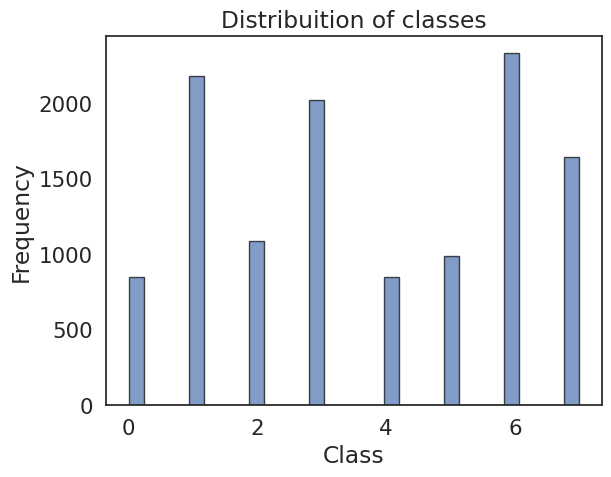

In [ ]:
# Create the histogram
plt.hist(y, bins=30, edgecolor='black', alpha=0.7)

# Add title and labels
plt.title('Distribuition of classes')
plt.xlabel('Class')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [ ]:
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
    # tfkl.RandomZoom(0.2),
    tfkl.RandomBrightness(0.5, value_range=(0,1)),
    tfkl.RandomContrast(0.75),
], name='augmentation')

I0000 00:00:1731118337.174400    1658 service.cc:145] XLA service 0x57311df00470 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731118337.174473    1658 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1731118337.174478    1658 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1731118337.174480    1658 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1731118337.174483    1658 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1731118337.174486    1658 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1731118337.174489    1658 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1731118337.174492    1658 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1731118337.174496    1658 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed,
    stratify=y
)

# Print the shapes of the resulting sets
print('Training set shape:\t', X_train.shape, y_train.shape)
print('Validation set shape:\t', X_val.shape, y_val.shape)

Training set shape:	 (9554, 96, 96, 3) (9554, 1)
Validation set shape:	 (2389, 96, 96, 3) (2389, 1)


In [ ]:
# Processing of data
X_train = (X_train / 255.).astype(np.float32)
X_val = (X_val / 255.).astype(np.float32)

# One-hot encoding of targets
y_train = tfk.utils.to_categorical(y_train, num_classes=8)
y_val = tfk.utils.to_categorical(y_val, num_classes=8)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]

print('Input shape:\t', input_shape)
print('Output shape:\t', output_shape)

Input shape:	 (96, 96, 3)
Output shape:	 8


In [ ]:
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
    DepthwiseConv2D, Dense, Activation, Multiply, Concatenate,
    AveragePooling2D, UpSampling2D, BatchNormalization, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Enable TPU
try:
    # Connect to the TPU and initialize it
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print("All TPU devices: ", tf.config.list_logical_devices('TPU'))
except ValueError:
    print("TPU not found. Using default strategy.")
    strategy = tf.distribute.get_strategy()  # Default strategy for CPU/GPU

def inception_module(x):
    # Branch 1x1
    branch1 = Conv2D(64, (1, 1), padding='same', activation='relu')(x)

    # Branch 3x3
    branch3 = Conv2D(96, (1, 1), padding='same', activation='relu')(x)
    branch3 = Conv2D(128, (3, 3), padding='same', activation='relu')(branch3)

    # Branch 5x5
    branch5 = Conv2D(16, (1, 1), padding='same', activation='relu')(x)
    branch5 = Conv2D(32, (5, 5), padding='same', activation='relu')(branch5)

    # Branch Pooling
    branch_pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = Conv2D(32, (1, 1), padding='same', activation='relu')(branch_pool)

    # Concatenate branches
    x = Concatenate()([branch1, branch3, branch5, branch_pool])
    return x

def squeeze_excite_block(input_tensor):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // 16, activation="relu")(se)
    se = Dense(filters, activation="sigmoid")(se)
    se = Multiply()([input_tensor, se])
    return se

def depthwise_se_block(x):
    x = DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1)(x)
    x = Conv2D(x.shape[-1], (1, 1), activation='relu')(x)
    return squeeze_excite_block(x)

def pyramid_pooling_module(x):
    pool_sizes = [1, 2, 3, 6]
    concat_list = [x]
    for size in pool_sizes:
        pooled = AveragePooling2D(pool_size=(size, size), strides=(size, size), padding='same')(x)
        pooled = Conv2D(128, (1, 1), activation='relu', padding='same')(pooled)
        pooled = UpSampling2D(size=(size, size), interpolation='bilinear')(pooled)
        concat_list.append(pooled)
    return Concatenate()(concat_list)

# Building model
with strategy.scope():
    inputs = Input(shape=input_shape)

    x = augmentation(inputs)

    # Initial conv block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Multi-branch CNN
    branch1 = inception_module(x)
    branch2 = depthwise_se_block(x)
    branch3 = pyramid_pooling_module(x)

    # Concatenate branches
    x = Concatenate()([branch1, branch2, branch3])

    # Final layers
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(8, activation='softmax')(x)  # 8 classes

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


# Display model architecture
model.summary()


All TPU devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


I0000 00:00:1731118344.143796    1658 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation        │ (None, 96, 96, 3) │          0 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 96, 96,    │      1,792 │ augmentation[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 48, 48,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 48, 48,    │        640 │ max_pooling2d[0]… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 48, 48,    │      4,160 │ depthwise_conv2d… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_7[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 48, 48,    │          0 │ max_pooling2d[0]… │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 24, 24,    │          0 │ max_pooling2d[0]… │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 16, 16,    │          0 │ max_pooling2d[0]… │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_3 │ (None, 8, 8, 64)  │          0 │ max_pooling2d[0]… │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 48, 48,    │      6,240 │ max_pooling2d[0]… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 48, 48,    │      1,040 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 48, 48,    │          0 │ max_pooling2d[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │        260 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 48, 48,    │      8,320 │ average_pooling2… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 24, 24,    │      8,320 │ average_pooling2… │
│                     │ 128)              │            │                 

 Total params: 1,211,388 (4.62 MB)

 Trainable params: 1,211,132 (4.62 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
batch_size = 128

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)


history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=1000,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=2
).history


# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

Epoch 1/100


I0000 00:00:1731118356.055404    2465 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(3ee83b31effd5426:0:0), session_name()


In [ ]:
model.save("MBCNN.keras")
del model
model = tfk.models.load_model("MBCNN.keras")

In [ ]:
# Create a figure with two vertically stacked subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 6), sharex=True)

# Plot training and validation loss
ax1.plot(history['loss'], label='Training loss', alpha=.8)
ax1.plot(history['val_loss'], label='Validation loss', alpha=.8)
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=.3)

# Plot training and validation accuracy
ax2.plot(history['accuracy'], label='Training accuracy', alpha=.8)
ax2.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(alpha=.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()


In [ ]:
print("TRAIN:")
# Predict class probabilities and get predicted classes
train_predictions = model.predict(X_train, verbose=0)
train_predictions = np.argmax(train_predictions, axis=-1)

# Extract ground truth classes
train_gt = np.argmax(y_train, axis=-1)

# Calculate and display training set accuracy
train_accuracy = accuracy_score(train_gt, train_predictions)
print(f'Accuracy score over the train set: {round(train_accuracy, 4)}')

# Calculate and display training set precision
train_precision = precision_score(train_gt, train_predictions, average='weighted')
print(f'Precision score over the train set: {round(train_precision, 4)}')

# Calculate and display training set recall
train_recall = recall_score(train_gt, train_predictions, average='weighted')
print(f'Recall score over the train set: {round(train_recall, 4)}')

# Calculate and display training set F1 score
train_f1 = f1_score(train_gt, train_predictions, average='weighted')
print(f'F1 score over the train set: {round(train_f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(train_gt, train_predictions)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='',   cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

print("VALIDATION:")
# Predict class probabilities and get predicted classes
val_predictions = model.predict(X_val, verbose=0)
val_predictions = np.argmax(val_predictions, axis=-1)

# Extract ground truth classes
val_gt = np.argmax(y_val, axis=-1)

# Calculate and display validation set accuracy
val_accuracy = accuracy_score(val_gt, val_predictions)
print(f'Accuracy score over the validation set: {round(val_accuracy, 4)}')

# Calculate and display validation set precision
val_precision = precision_score(val_gt, val_predictions, average='weighted')
print(f'Precision score over the validation set: {round(val_precision, 4)}')

# Calculate and display validation set recall
val_recall = recall_score(val_gt, val_predictions, average='weighted')
print(f'Recall score over the validation set: {round(val_recall, 4)}')

# Calculate and display validation set F1 score
val_f1 = f1_score(val_gt, val_predictions, average='weighted')
print(f'F1 score over the validation set: {round(val_f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(val_gt, val_predictions)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='',   cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import numpy as np


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('MBCNN.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        X = (X / 255.).astype(np.float32)
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

In [ ]:
from datetime import datetime
filename = f'submission_MBCNN{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py first_attempt.keras